<a href="https://colab.research.google.com/github/yma3/Path-of-Exile-Currency-Prediction/blob/master/POE_League_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from datetime import datetime
import pandas as pd


import tensorflow as tf
print(tf.__version__)
import numpy as np

import matplotlib.pyplot as plt

2.3.0


In [2]:
dir = '/content/drive/My Drive/ColabData/POEData/'
os.listdir(dir)

['Metamorph.2019-12-13.2020-03-09.currency.csv',
 'Metamorph.2019-12-13.2020-03-09.items.csv',
 'Blight.2019-09-06.2019-12-09.currency.csv',
 'Blight.2019-09-06.2019-12-09.items.csv',
 'Legion.2019-06-07.2019-09-02.currency.csv',
 'Legion.2019-06-07.2019-09-02.items.csv',
 'Synthesis.2019-03-08.2019-06-04.currency.csv',
 'Synthesis.2019-03-08.2019-06-04.items.csv',
 'Betrayal.2018-12-07.2019-03-05.items.csv',
 'Betrayal.2018-12-07.2019-03-05.currency.csv',
 'Delve.2018-08-31.2018-12-03.currency.csv',
 'Delve.2018-08-31.2018-12-03.items.csv',
 'Incursion.2018-06-01.2018-08-28.items.csv',
 'Incursion.2018-06-01.2018-08-28.currency.csv',
 'Delirium.2020-03-13.2020-06-15.items.csv',
 'Delirium.2020-03-13.2020-06-15.currency.csv',
 'exalteddf.csv']

In [3]:
exdf = pd.read_csv(dir+'exalteddf.csv')

In [46]:
# exdf = exdf[exdf['League'] == 'Betrayal']

In [66]:
exdf.head()
exdf[exdf['League']=='Delirium']

,Unnamed: 0,League,Date,Get,Pay,Value,Confidence,Day_Diff
631,2970,Delirium,2020-03-13,Exalted Orb,Chaos Orb,23.57778,Medium,462
632,2971,Delirium,2020-03-14,Exalted Orb,Chaos Orb,63.00000,High,463
633,2972,Delirium,2020-03-15,Exalted Orb,Chaos Orb,81.00000,High,464
634,2973,Delirium,2020-03-16,Exalted Orb,Chaos Orb,103.00000,High,465
635,2974,Delirium,2020-03-17,Exalted Orb,Chaos Orb,97.00976,High,466
...,...,...,...,...,...,...,...,...
716,3055,Delirium,2020-06-11,Exalted Orb,Chaos Orb,138.00000,High,552
717,3056,Delirium,2020-06-12,Exalted Orb,Chaos Orb,138.00000,High,553
718,3057,Delirium,2020-06-13,Exalted Orb,Chaos Orb,140.00028,High,554
719,3058,Delirium,2020-06-14,Exalted Orb,Chaos Orb,144.35077,High,555


In [67]:
START_DATE = '2018-12-07'
exdf['Date'] = pd.to_datetime(exdf['Date'])
# exdf['Date'] = exdf['Date'].values.astype(int)
START_DATE = datetime.strptime(START_DATE, '%Y-%m-%d')

exdf['Day_Diff'] = (exdf['Date'] - START_DATE).dt.days
exdf = exdf[exdf['Day_Diff'] >= 0]

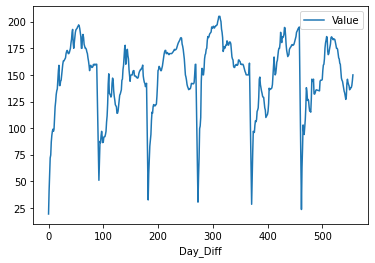

In [68]:
exdf
exdf.plot.line('Day_Diff','Value')

In [7]:
time = exdf['Day_Diff'].values
series = exdf['Value'].values


In [79]:
SPLIT = 448


time_train = time[:SPLIT]
x_train = series[:SPLIT]
time_valid = time[SPLIT:]
x_valid = series[SPLIT:]



23.57778


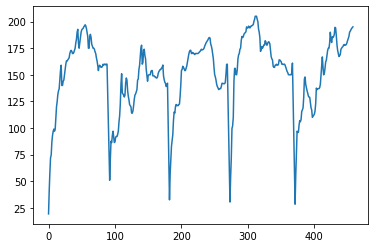

In [80]:
print(x_valid[0])
plt.figure()
plt.plot(time_train, x_train)

# Naives Forecast


In [84]:
naive_forecast = series[SPLIT - 1:-1]
naive_forecast[0] = 0

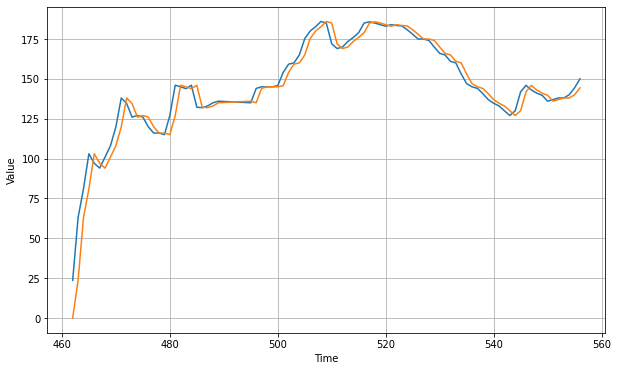

In [85]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

In [86]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

60.45992490388667
4.709701555555557


# Moving Average


In [87]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

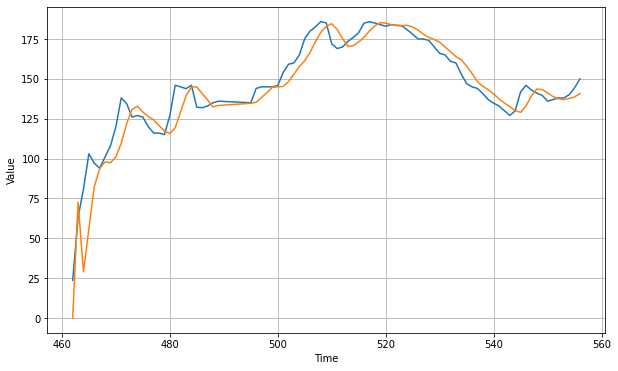

In [90]:
moving_avg = moving_average_forecast(series, 3)[SPLIT - 3:]
moving_avg[0] = 0
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [91]:
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

127.58348361687446
7.558645592592594


# Deep Learning Solution

In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [59]:
def model_forecast(model, series, window_size, batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [60]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [92]:
tf.random.set_seed(51)
np.random.seed(51)
WINDOW = 5
BATCH = 32
SHUFFLE_BUFFER = 100
EPOCHS = 2000

train_set = windowed_dataset(x_train, WINDOW, BATCH, SHUFFLE_BUFFER)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
])

def lrscheduler(epoch, lr):
  scheduler = [400, 750, 1100]
  if epoch in scheduler:
    return lr/3
  else:
    return lr


# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(-epoch/250))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrscheduler)

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss = tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

model.summary()

history = model.fit(train_set, epochs=EPOCHS, callbacks=[lr_schedule])
# history = model.fit(train_set, epochs=EPOCHS)




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(448,)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, None, 64)          256       
_________________________________________________________________
lstm_45 (LSTM)               (None, None, 128)         98816     
_________________________________________________________________
lstm_46 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_47 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
dense_62 (Dense)             (None, None, 64)          8256      
_________________________________________________________________
dense_63 (Dense)             (None, None, 32)          2080      
__________________

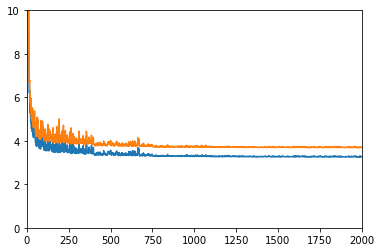

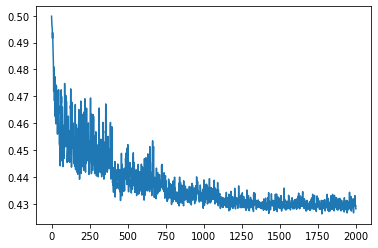

In [93]:
plt.plot(range(EPOCHS), history.history["loss"])
plt.plot(range(EPOCHS), history.history["mae"])
diff = []
for i in range(len(history.history["loss"])):
  diff.append(history.history["mae"][i]-history.history["loss"][i])

plt.axis([0, EPOCHS, 0, 10])


plt.figure(2)
plt.plot(range(EPOCHS), diff)


In [94]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], WINDOW, BATCH)
rnn_forecast = rnn_forecast[SPLIT - WINDOW:-1, -1, 0]

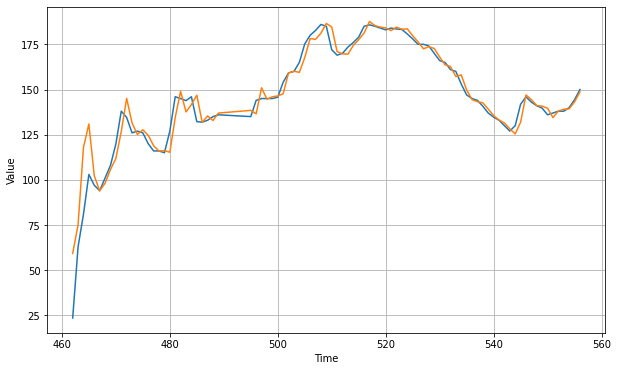

In [95]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [96]:
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

58.68717
4.194165


In [97]:
model.save(dir+'exaltedorbmodel.h5')

In [58]:
dataset = tf.data.Dataset.from_tensor_slices((exdf['Day_Diff'].values, exdf['Value'].values))

In [59]:
for feat, targ in dataset.take(6):
  print ('Features: {}, Target: {}'.format(feat, targ))


Features: 0, Target: 19.34105
Features: 1, Target: 41.0
Features: 2, Target: 58.0
Features: 3, Target: 72.0
Features: 4, Target: 74.72035
Features: 5, Target: 87.0


In [ ]:
split_time = 

True